# 2. Earthquakes dataset with Agglomerative Clustering

---
### Loading the libraries

In [1]:
import numpy as np
import random
import copy
import tqdm

import plotly.express as px
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.model_selection import ParameterGrid

from plyfile import PlyData

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

---
### Read the Dataset

In [2]:
ply_data =PlyData.read('earthquakes.ply')

In [3]:
x = ply_data.elements[0].data['x']
y = ply_data.elements[0].data['y']
z = ply_data.elements[0].data['z']

x = x.reshape(-1, 1)
y = y.reshape(-1, 1)
z = z.reshape(-1, 1)

data = np.concatenate((x,y,z), axis=-1)
np.random.shuffle(data)

In [4]:
org_data = copy.copy(data)

---
### Sampling the data

In [5]:
def sample_data(in_data: np.array, reduction_factor: int) -> np.array:
    total_rows = data.shape[0]
    row_ids = np.random.choice(total_rows, total_rows // reduction_factor, replace=False)
    ret_data = in_data[row_ids]
    return ret_data

In [6]:
print('Original Dataset shape: ', org_data.shape)

sample = 16
data = sample_data(org_data, sample)
print(f'1/{sample} Sample Dataset:     {data.shape}')

x = data[:,0]
y = data[:,1]
z = data[:,2]

print('Shape of x:             ', x.shape)
print('Shape of y:             ', y.shape)
print('Shape of z:             ', z.shape)

Original Dataset shape:  (521721, 3)
1/16 Sample Dataset:     (32607, 3)
Shape of x:              (32607,)
Shape of y:              (32607,)
Shape of z:              (32607,)


---
### Metric for evaluating the quality of clustering - Silhouette score 

In [7]:
def sil_eval(model, parameter_grid, data: np.array) -> tuple:
    best_score = -1
    best_grid = None
    n_labs = 0

    for params in tqdm.tqdm(parameter_grid):
        model.set_params(**params)
        model.fit(data)
        n_unique_labels = len(np.unique(model.labels_))
        if n_unique_labels == 1:
            continue
        current_score = silhouette_score(data, model.labels_)
        if current_score > best_score:
            best_score = current_score
            best_grid = params
            n_labs = n_unique_labels
    return best_score, best_grid, n_labs

---
### Agglomerative Clustering model with grid parameters

In [8]:
model_agg = AgglomerativeClustering()

parameters = {
    'linkage': ['ward', 'complete', 'average', 'single'],
    'n_clusters': [2,3,4,5,7,8,9,10,12,14,15,16,18,19,20,21], 
    'distance_threshold': [None]
}
parameter_grid = ParameterGrid(parameters)
best_score, best_params, n_labs = sil_eval(model_agg, parameter_grid, data)

print('Best Score:      ', best_score)
print('Best Parameters: ', best_params)
print('Number of Labels:', n_labs)

100%|██████████| 64/64 [1:40:21<00:00, 94.08s/it] 

Best Score:       0.5748882
Best Parameters:  {'distance_threshold': None, 'linkage': 'ward', 'n_clusters': 15}
Number of Labels: 15


In [9]:
# Perform Agglomerative Clustering with best parametars

final_ag = AgglomerativeClustering(linkage=best_params['linkage'], n_clusters=best_params['n_clusters'],  distance_threshold=None)
final_ag.fit(data)
final_ag_labels = final_ag.labels_

In [10]:
fig = px.scatter_3d(x=x.flatten(), y=y.flatten(), z=z.flatten(), color=final_ag.labels_)
fig.update_traces(marker_size=1)
fig.show()

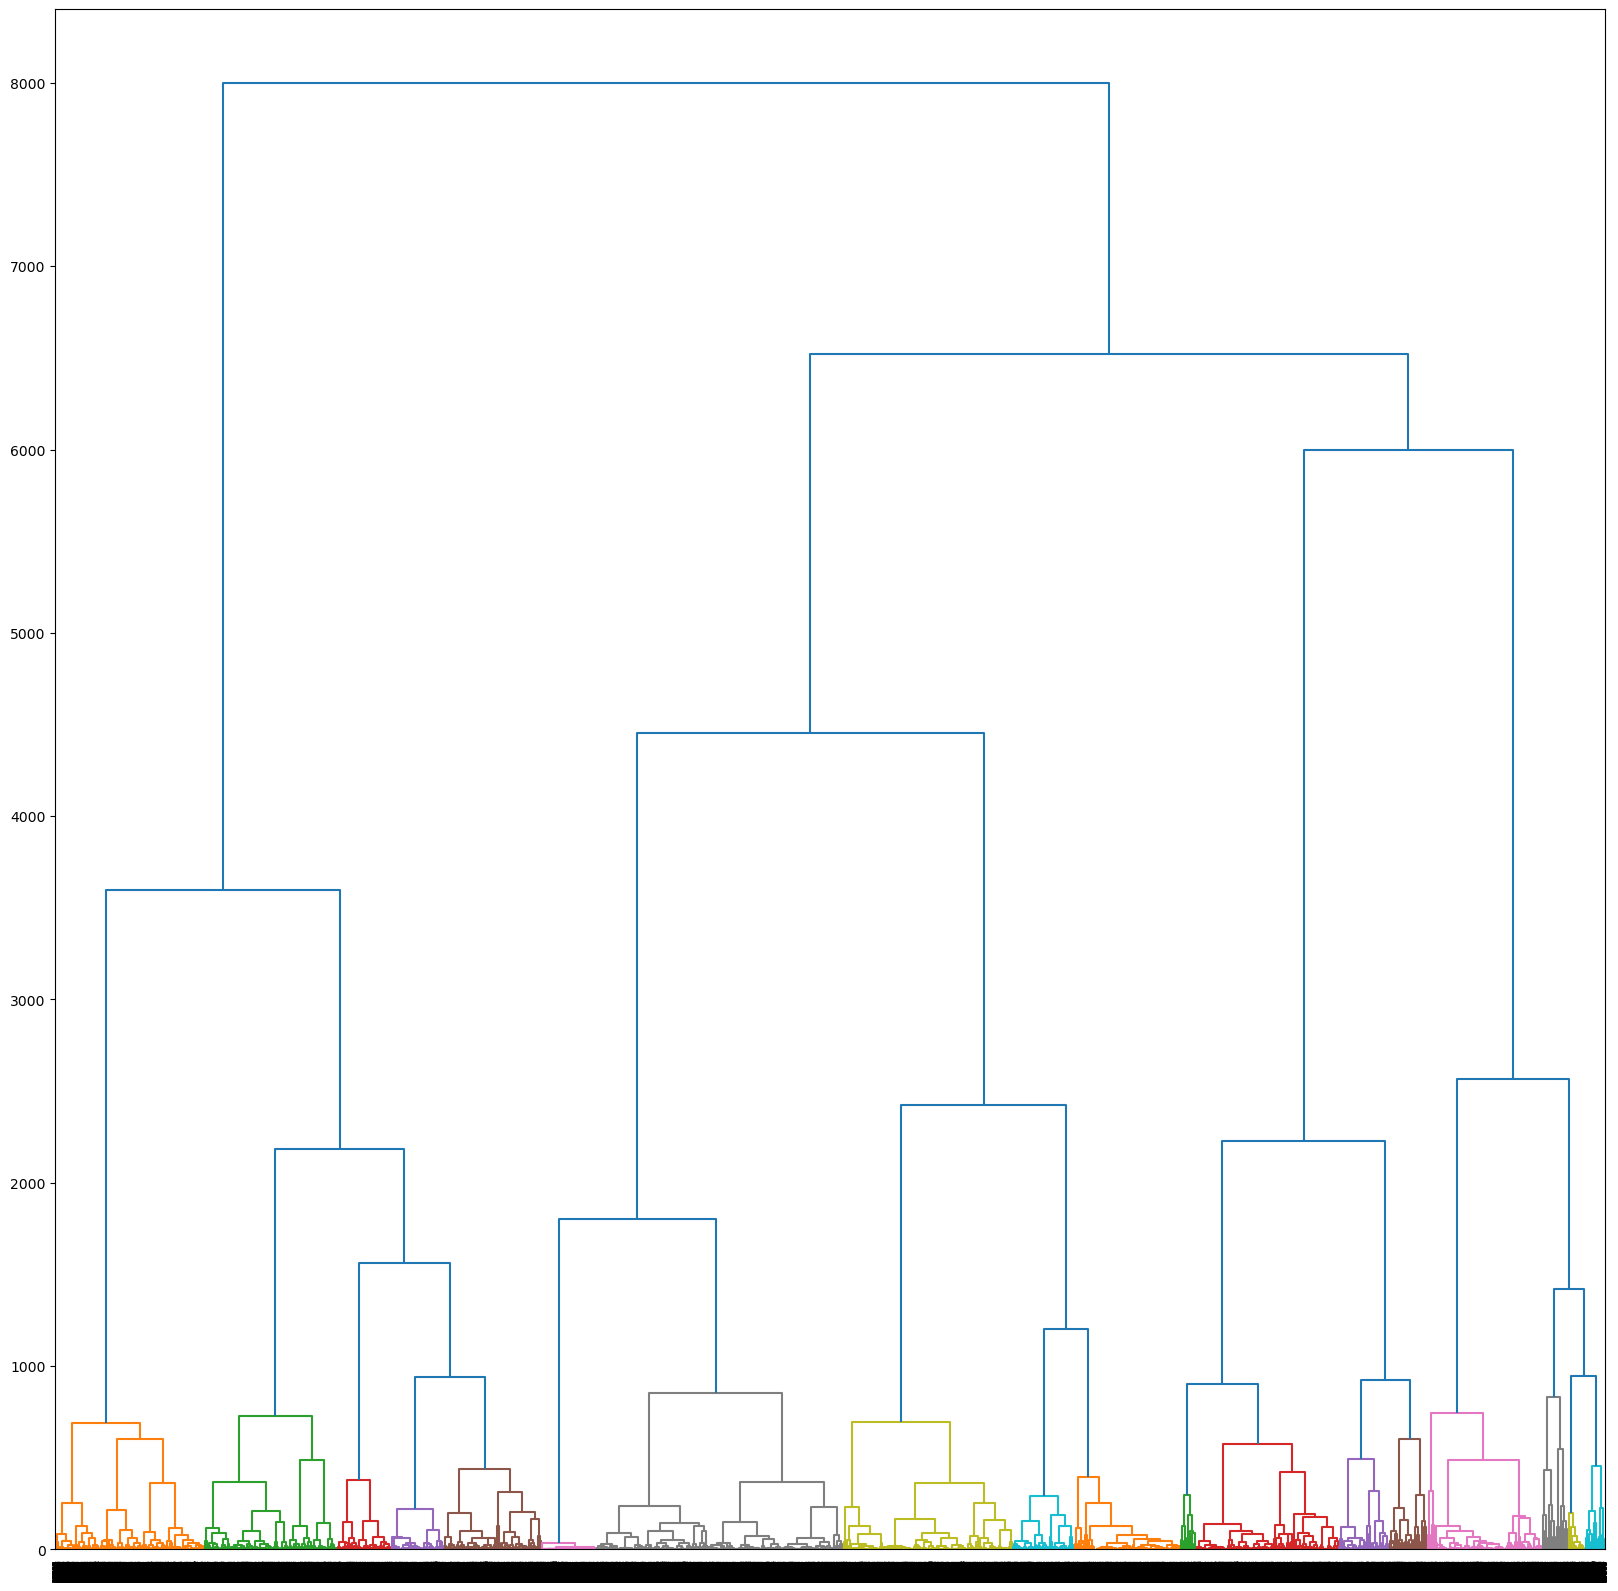

In [11]:
output = linkage(data, 'ward')

fig = plt.figure(figsize=(20,20))
dendrogram(output, color_threshold=900)
plt.show()

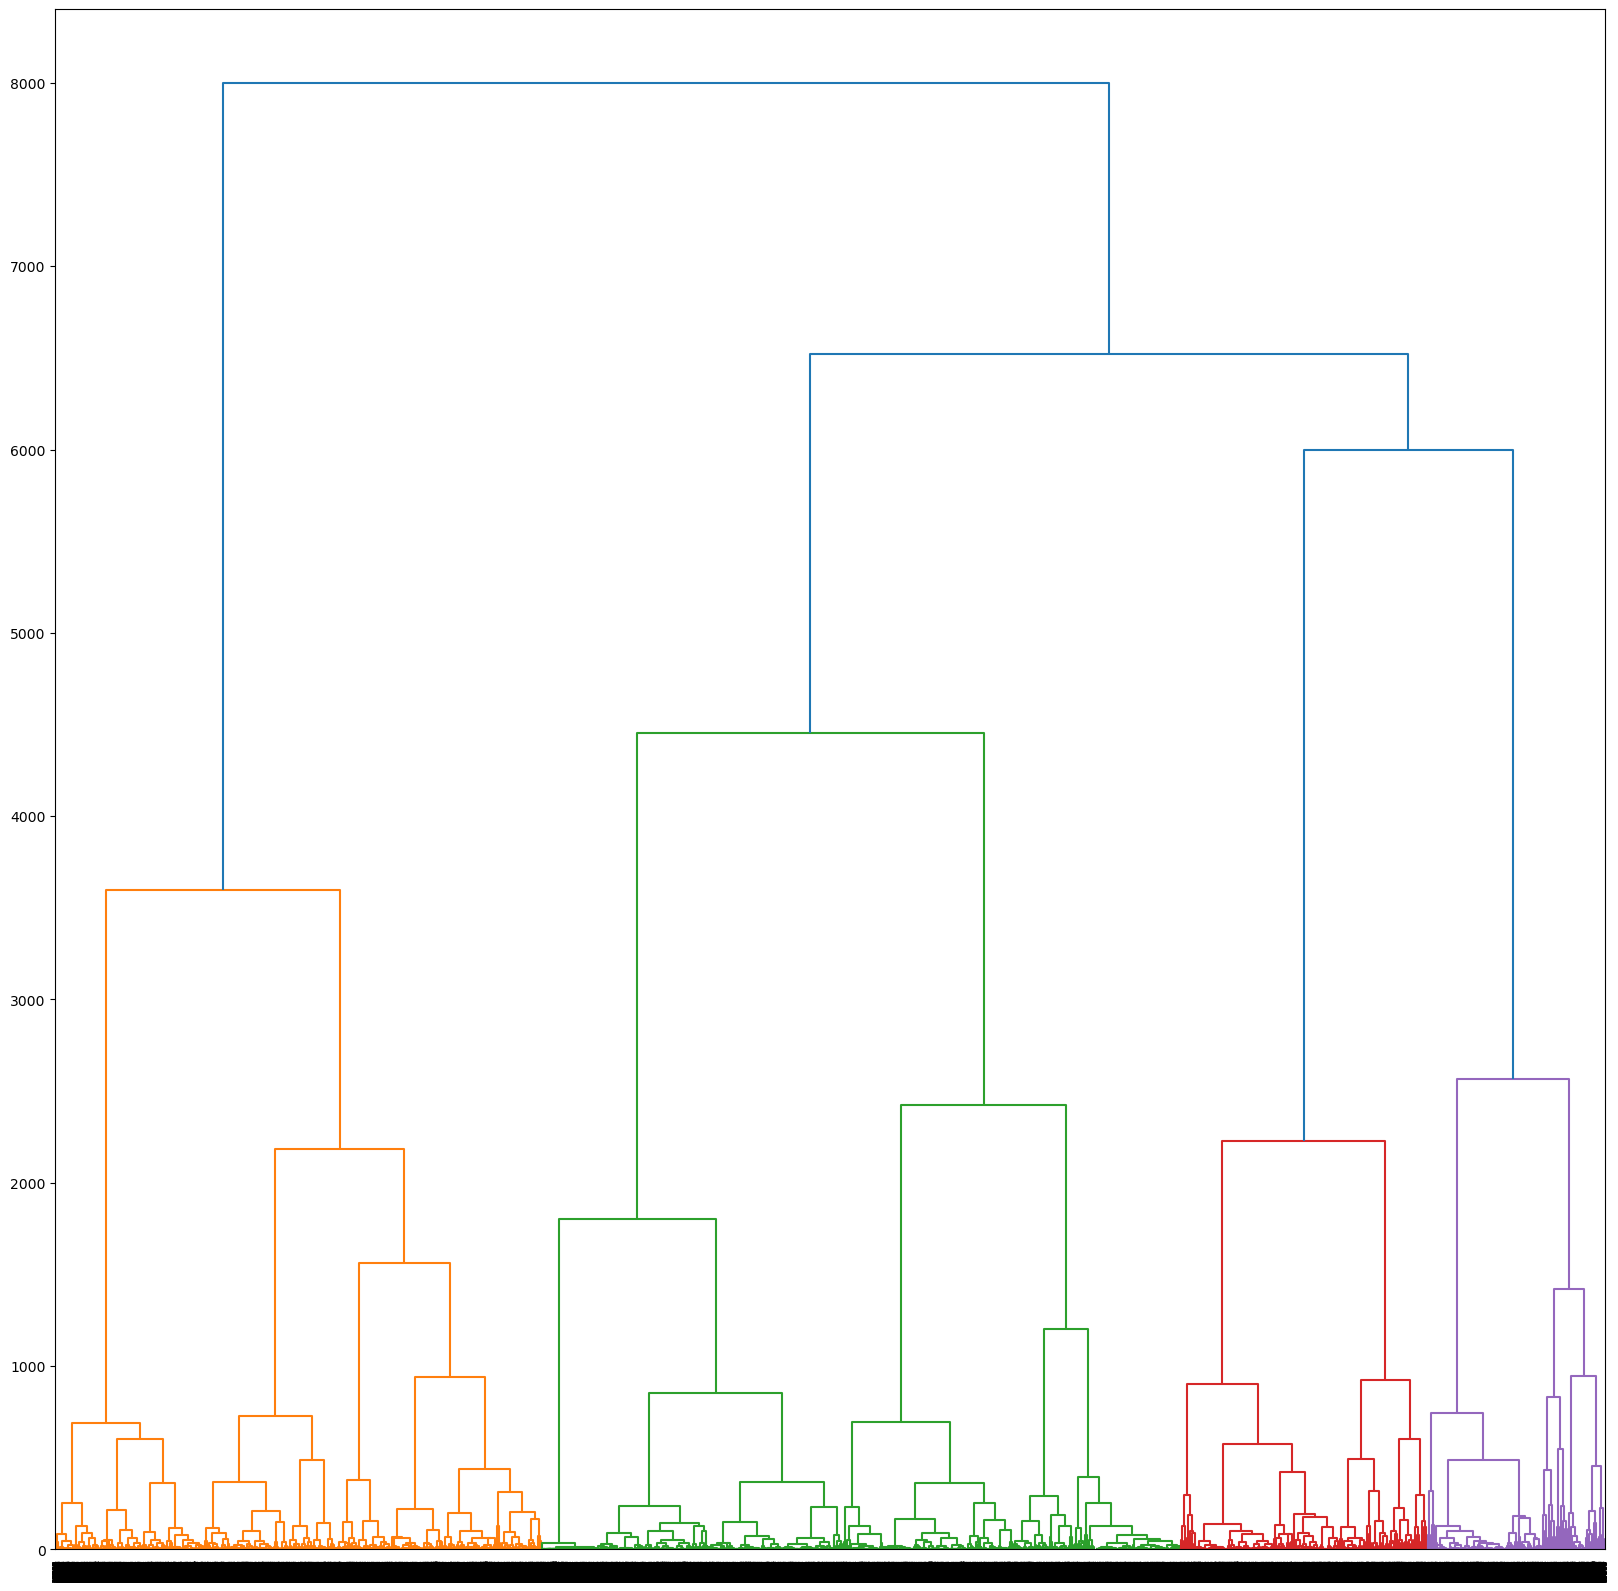

In [12]:
# Dendrogram with deafult theshold shows only 4 clusters

output = linkage(data, 'ward')

fig = plt.figure(figsize=(20,20))
dendrogram(output)
plt.show()

---
# RESULTS:


### Agglomerative Clustering model with grid parameters

Agglomerative Clustering model gave satisfiying Silhouette score with 15 clusters, clear boundaries between clusters, without overlapping clusters.    
In my opinion this is the best model for this kind of clustering problem, because it doesn't have prefered shape as kMeans, and it is not affected by the density as DBScan.

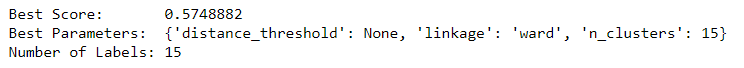

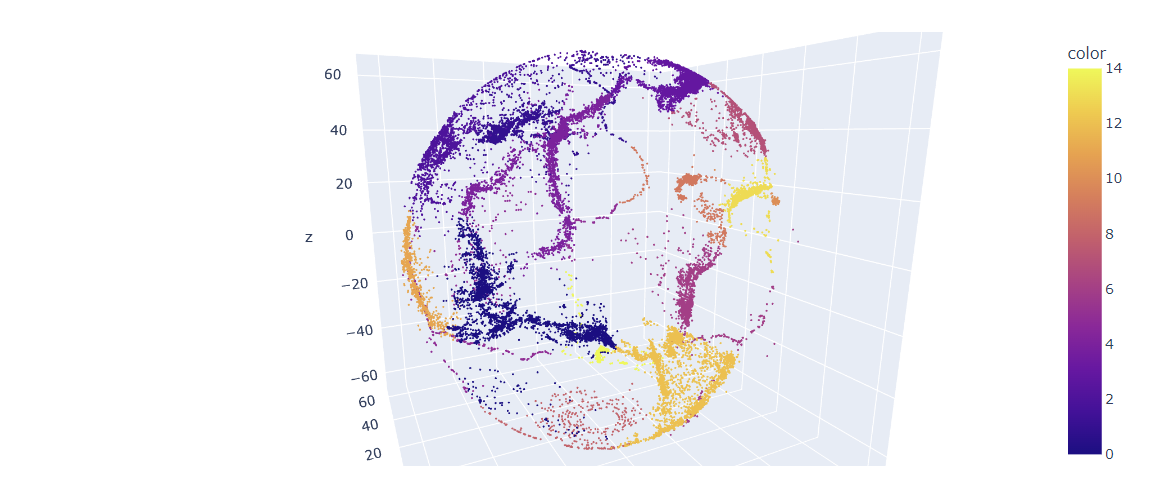